# Arrests and Crime Severity by Neighborhood

## Introduction  
To evaluate the happiest neighborhood in Pittsburgh, one important submetric is **safety**.  
This analysis focuses on **arrests over the past 3 years**, weighted by the **severity of crime**.  
Higher-weight crimes (e.g., Homicide, Aggravated Assault) contribute more to the total score than lower-weight ones (e.g., Disorderly Conduct).


### Data Cleaning & Setup 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Datasets/Pittsburgh_Police_Arrest_Data.csv")
df['OFFENSES'] = df['OFFENSES'].fillna("")
df['ARRESTTIME'] = pd.to_datetime(df['ARRESTTIME'], errors='coerce')
df['ARREST_YEAR'] = df['ARRESTTIME'].dt.year

### Crime Weighting System  
Each offense is mapped to a category with a corresponding severity weight:

- Homicide: 5  
- Aggravated Assault / Robbery: 4  
- Burglary: 3  
- Theft / Drug Offenses: 2  
- Disorderly Conduct / Public Drunkenness / Other: 1  

This allows us to compute a **weighted crime score** per neighborhood.

In [28]:
crime_weights = {
    'Homicide': 5,
    'Aggravated Assault': 4,
    'Robbery': 4,
    'Burglary': 3,
    'Theft': 2,
    'Drug': 2,
    'Disorderly Conduct': 1,
    'Public Drunkenness': 1,
    'Other': 1
}

def classify_crime(offense_str):
    offense_str = offense_str.lower()
    if 'homicide' in offense_str:
        return 'Homicide'
    elif 'aggravated assault' in offense_str:
        return 'Aggravated Assault'
    elif 'robbery' in offense_str:
        return 'Robbery'
    elif 'burglary' in offense_str:
        return 'Burglary'
    elif 'theft' in offense_str:
        return 'Theft'
    elif 'drug' in offense_str or 'controlled substance' in offense_str:
        return 'Drug'
    elif 'disorderly conduct' in offense_str:
        return 'Disorderly Conduct'
    elif 'drunkenness' in offense_str:
        return 'Public Drunkenness'
    else:
        return 'Other'

df['CRIME_CATEGORY'] = df['OFFENSES'].apply(classify_crime)
df['CRIME_WEIGHT'] = df['CRIME_CATEGORY'].map(crime_weights)


In [29]:
latest_year = df['ARREST_YEAR'].max()
recent_df = df[df['ARREST_YEAR'].between(latest_year - 2, latest_year)]

score_by_neighborhood = recent_df.groupby('INCIDENTNEIGHBORHOOD')['CRIME_WEIGHT'].sum().dropna()
score_by_neighborhood = score_by_neighborhood[score_by_neighborhood.index != 'Outside City']
score_by_neighborhood = score_by_neighborhood.sort_values()


### Top 15 Safest Neighborhoods 

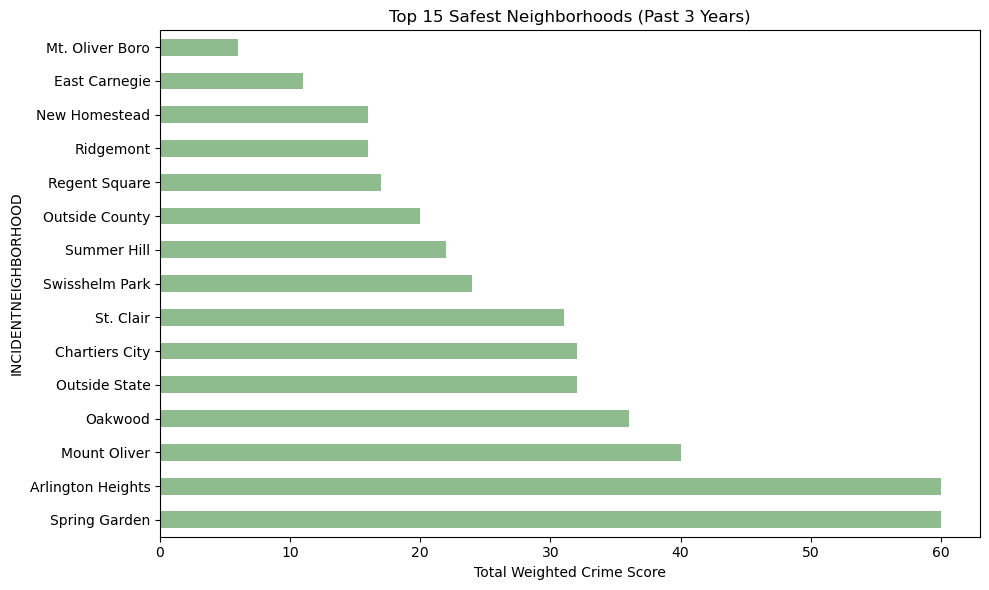

In [49]:
top_safe = score_by_neighborhood.head(15)
plt.figure(figsize=(10, 6))
top_safe.plot(kind='barh',color = "darkseagreen", title="Top 15 Safest Neighborhoods (Past 3 Years)")
plt.xlabel("Total Weighted Crime Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top 15 Most Dangerous Neighborhoods  

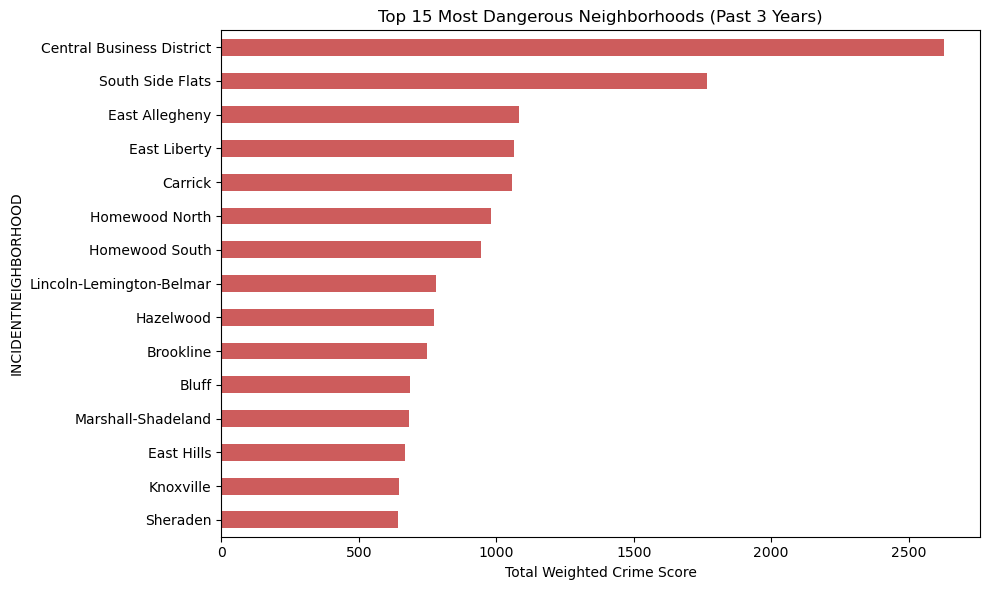

In [50]:
top_dangerous = score_by_neighborhood.tail(15).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
top_dangerous.plot(kind='barh', color='indianred', title="Top 15 Most Dangerous Neighborhoods (Past 3 Years)")
plt.xlabel("Total Weighted Crime Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Table: Safest vs. Most Dangerous  

In [32]:
safe_df = top_safe.reset_index().rename(columns={'INCIDENTNEIGHBORHOOD': 'Neighborhood', 'CRIME_WEIGHT': 'Crime Score'})
dangerous_df = top_dangerous.reset_index().rename(columns={'INCIDENTNEIGHBORHOOD': 'Neighborhood', 'Crime Score': 'Crime Score'})
comparison_df = pd.concat([
    safe_df.assign(Category="Safest"),
    dangerous_df.assign(Category="Most Dangerous")
])
comparison_df

,Neighborhood,Crime Score,Category,CRIME_WEIGHT
0,Mt. Oliver Boro,6.0,Safest,NaN
1,East Carnegie,11.0,Safest,NaN
2,New Homestead,16.0,Safest,NaN
3,Ridgemont,16.0,Safest,NaN
4,Regent Square,17.0,Safest,NaN
5,Outside County,20.0,Safest,NaN
6,Summer Hill,22.0,Safest,NaN
7,Swisshelm Park,24.0,Safest,NaN
8,St. Clair,31.0,Safest,NaN
9,Chartiers City,32.0,Safest,NaN


### Crime Trends Over Time 

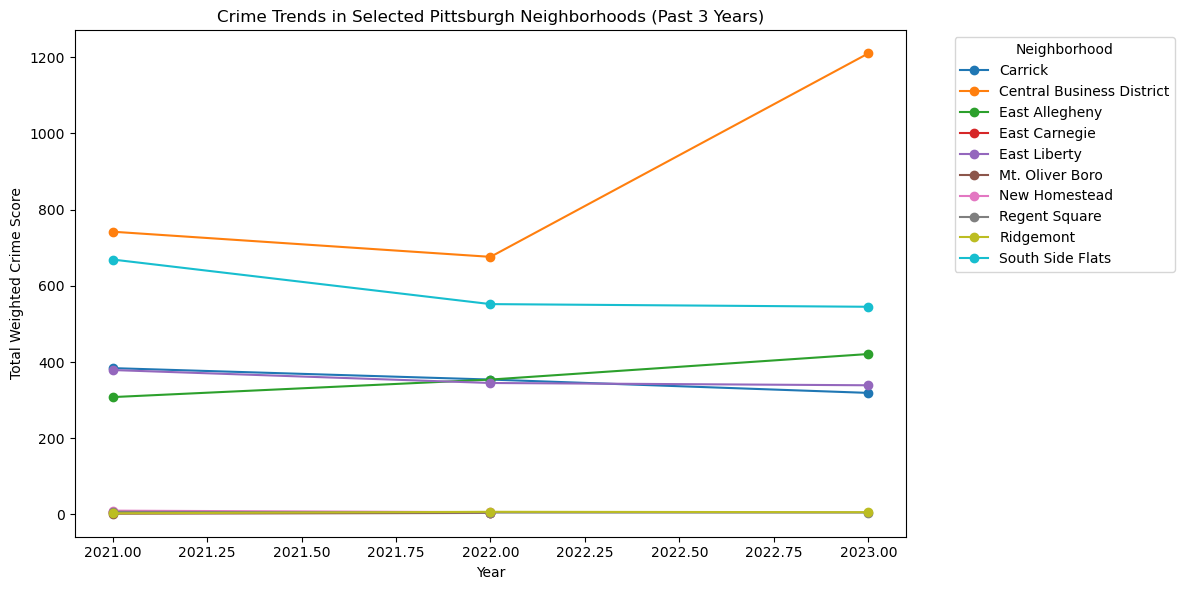

In [33]:
trend_df = recent_df.groupby(['INCIDENTNEIGHBORHOOD', 'ARREST_YEAR'])['CRIME_WEIGHT'].sum().reset_index()
selected_neighs = top_safe.head(5).index.tolist() + top_dangerous.head(5).index.tolist()
trend_df = trend_df[trend_df['INCIDENTNEIGHBORHOOD'].isin(selected_neighs)]

plt.figure(figsize=(12, 6))

for neighborhood in trend_df['INCIDENTNEIGHBORHOOD'].unique():
    subset = trend_df[trend_df['INCIDENTNEIGHBORHOOD'] == neighborhood]
    plt.plot(subset['ARREST_YEAR'], subset['CRIME_WEIGHT'], marker='o', label=neighborhood)

plt.title("Crime Trends in Selected Pittsburgh Neighborhoods (Past 3 Years)")
plt.xlabel("Year")
plt.ylabel("Total Weighted Crime Score")
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

